In [1]:
import pandas
import numpy 
import glob
from matplotlib import pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

# Importing and Visualizing the Data

## Data Classes

We'll need to make a couple of classes for our imported data that will be used with both gesture recogntion methods. The `Data` class holds the data for a gesture from either the accelerometer or gyroscope. Since each gesture has data from both sensors, the `Gesture` class contains two instances of the `Data` class, one for each sensor for every given gesture 

In [2]:
# class that holds the data of a gesture, either accel or gyro
class Data:
    def __init__(self, sensor_type, current_time, timestamp, x, y, z):
        
        self.sensor_type = sensor_type
        self.current_time = current_time
        self.timestamp = timestamp
        
        # save x y z as float type 
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
        self.mag = numpy.sqrt(self.x**2 + self.y**2 + self.z**2)

    # very useful function to add 0s to the end of an array from Jon Froehlich 
    def pad_with_zeros(self, new_len):
        self.prev_len = len(self.x)
        diff = new_len - len(self.x)
        if diff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(new_len, len(self.x)))
    
        self.x = numpy.pad(self.x, (0, diff), 'constant', constant_values=0)
        self.y = numpy.pad(self.y, (0, diff), 'constant', constant_values=0)
        self.z = numpy.pad(self.z, (0, diff), 'constant', constant_values=0)
        self.mag = numpy.pad(self.mag, (0, diff), 'constant', constant_values=0)
        
        
# class that holds the two accel and gyro Data objects for each gesture trial
class Gesture:
    def __init__(self, gesture_name, end_time, id_number, accel, gyro):
        
        # our two Data objects for the trial
        self.acceleration = accel
        self.gyroscope = gyro
        
        self.delta_x_accel = self.acceleration.x.max() - self.acceleration.x.min()
        self.gesture_name = gesture_name
        self.end_time = end_time
        self.id_number = id_number


### Loading in the Data

Now, we import the csv data and create instances of the classes above. This function will take in a list of the raw csv data and converts it into the relevant class instances in dictionaries.

In [3]:
import platform

# function to create class instances given csv data
def load_data(data_list):
    
    data_result = defaultdict(list)
    gestures = set()
    
    # load data into an array 
    for file in data_list:
        if platform.system() == 'Windows':
            cleaned_file = file.split("\\")[1].split(".")
        else:
            cleaned_file = file.split("/")[1].split(".")
        split_name = cleaned_file[0].split("_")
        this_gesture = split_name[0]
        this_sensor = split_name[1]
        this_time = int(split_name[2])

        this_data = pandas.read_csv(file, skipinitialspace=True)
    
        gestures.add((this_gesture, this_time))
        data_result[(this_gesture, this_time)].append({"data": this_data,"gesture": this_gesture,"sensor": this_sensor,"time": this_time})

    cleaned_data_result = defaultdict(list)
    gesture_counts = defaultdict(int)
    longest_sensor_data_list = 0
    
    for gesture in gestures:
        gesture_counts[gesture[0]] = gesture_counts[gesture[0]] + 1
        new = []
    
        for i in data_result[gesture]:
            d = Data(i['sensor'], i['time'], i['data']['SensorTimestampNano'], i['data']['X'], i['data']['Y'], i['data']['Z'])
            new.append(d)
            
            if len(d.x) > longest_sensor_data_list:
                longest_sensor_data_list = len(d.x)
        
        cleaned_data_result[gesture[0]].append(Gesture(gesture[0], gesture[1], gesture_counts[gesture[0]], new[0], new[1]))

    
    for gesture in cleaned_data_result:
        for obj in cleaned_data_result[gesture]:
            # resize the data arrays to match the longest
            obj.acceleration.pad_with_zeros(longest_sensor_data_list)
            obj.gyroscope.pad_with_zeros(longest_sensor_data_list)
            #print({obj.gesture_name, obj.id_number})
            
    return cleaned_data_result

Now, we can load in the csv files and create the dictionaries of data.

In [4]:
provided_files = glob.glob("providedGestureLogs/*.csv")
collected_files = glob.glob("recordedGestureLogs/*.csv")

cleaned_provided_data = load_data(provided_files)
cleaned_recorded_data = load_data(collected_files)

Now, we have all the data loaded into a dictionary with keys that correspond to the names of the gestures. So, I could say `cleaned_provided_data['Backhand Tennis']` to access the list of each of the backhand tennis trials. 

### Cleaning up the Data

I'm going to detrend the magnitude data for all of the gestures to try and normalize the signals. I'm just doing this for the acceleration data, since this is what I'll use in my classifiers below. 

In [5]:
from scipy import signal
import warnings
# hiding some useless warning
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# for gesture in cleaned_provided_data:
#     for obj in cleaned_provided_data[gesture]:
#         obj.mag = signal.detrend(obj.acceleration.mag)
        
# for gesture in cleaned_recorded_data:
#     for obj in cleaned_recorded_data[gesture]:
#         obj.mag = signal.detrend(obj.acceleration.mag)

## Visualizing the Gesture Sets

Using `matplotlib` we'll create visualizations of each of the gestures' raw acceleration signal data. 

### Recorded Gesture Set

I'll plot each of the gestures from the data set that I recorded. 

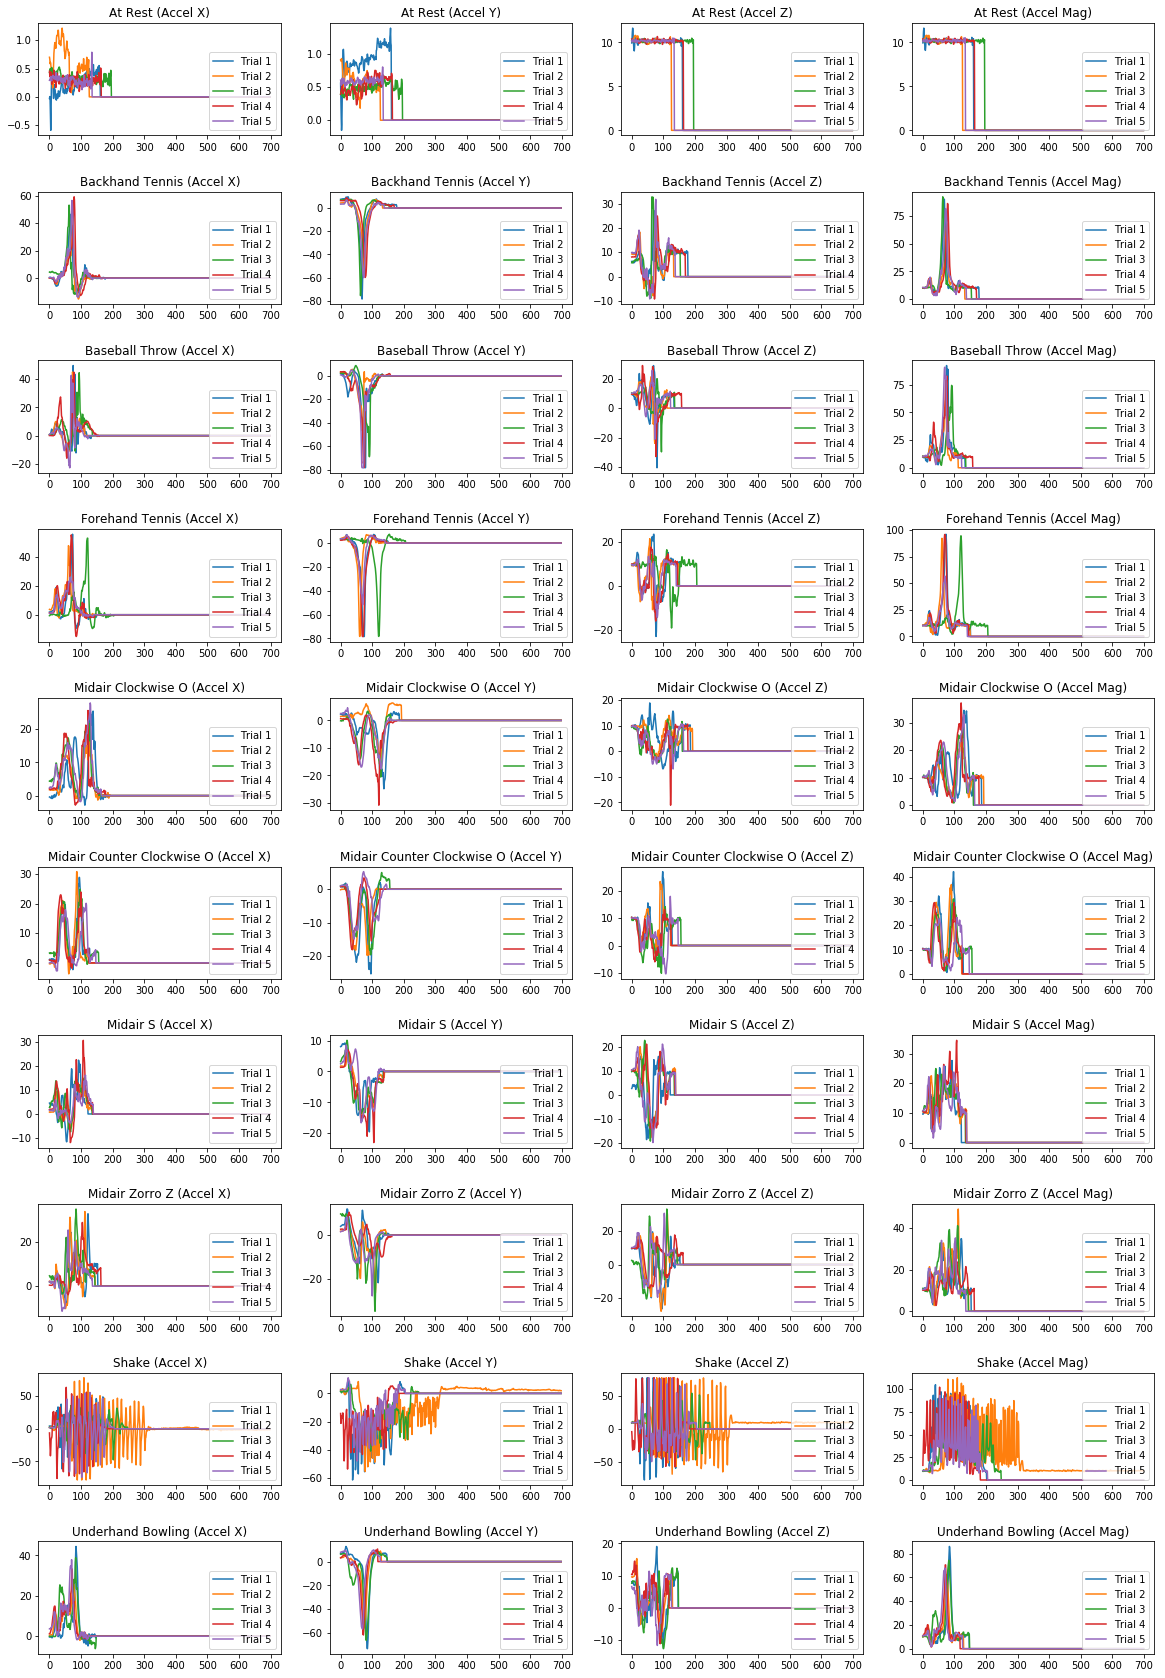

In [6]:
# the organization of these plots is from Jon Froehlich
fig, ax = plt.subplots(len(cleaned_recorded_data), 4, figsize=(20, 3 * len(cleaned_recorded_data)))
fig.subplots_adjust(hspace=0.5)

index = 0
gesture_names = sorted(cleaned_recorded_data.keys())

for gesture in gesture_names:
    trials = cleaned_recorded_data[gesture]
    trialNum = 1
    
    for trial in trials:
        ax[index][0].plot(trial.acceleration.x, label="Trial {}".format(trialNum))
        ax[index][1].plot(trial.acceleration.y, label="Trial {}".format(trialNum))
        ax[index][2].plot(trial.acceleration.z, label="Trial {}".format(trialNum))
        ax[index][3].plot(trial.acceleration.mag, label="Trial {}".format(trialNum))
        trialNum += 1
        
    ax[index][0].set_title(gesture + " (Accel X)")
    ax[index][0].legend(loc=4)
    ax[index][1].set_title(gesture + " (Accel Y)")
    ax[index][1].legend(loc=4)
    ax[index][2].set_title(gesture + " (Accel Z)")
    ax[index][2].legend(loc=4)
    ax[index][3].set_title(gesture + " (Accel Mag)")
    ax[index][3].legend(loc=4)
    index += 1

### Comparing Provided and Recorded Gesture Sets

There are two gesture sets, so I'd like to compare them. Chances are how each gesture was recorded in each set was different, so here I visualize some of those differences. 

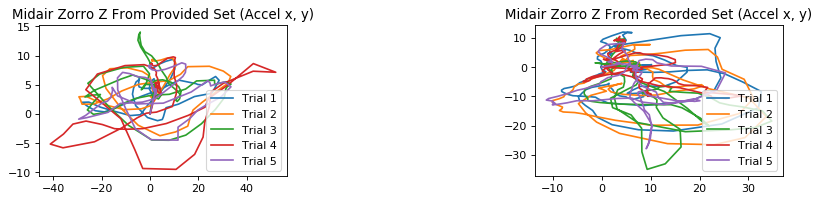

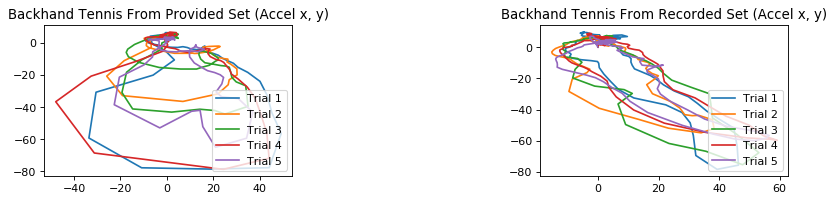

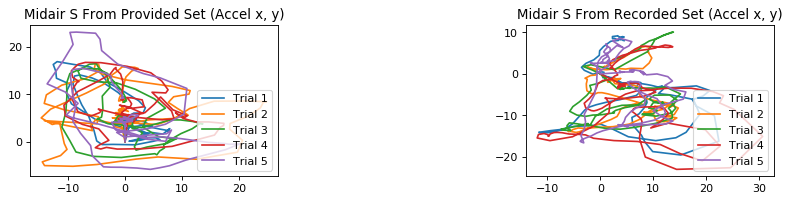

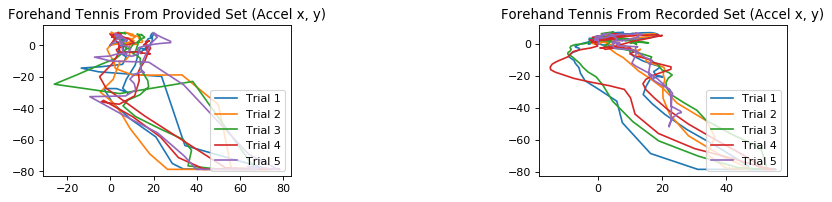

In [9]:
def plot_both_sets(gesture):

    fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(wspace = 1, hspace=0.4)

    ax = fig.add_subplot(2, 2, 1)
    trials = cleaned_provided_data[gesture]
    trialNum = 1
    
    for trial in trials:
        ax.plot(numpy.array(trial.acceleration.x), 
                numpy.array(trial.acceleration.y), label="Trial {}".format(trialNum))
        trialNum += 1
        
    ax.set_title("{} From Provided Set (Accel x, y)".format(gesture))
    ax.legend(loc=4)

    ax = fig.add_subplot(2, 2, 2)
    trials = cleaned_recorded_data[gesture]
    trialNum = 1
    
    for trial in trials:
        ax.plot(numpy.array(trial.acceleration.x), 
                numpy.array(trial.acceleration.y), label="Trial {}".format(trialNum))
        trialNum += 1
        
    ax.set_title("{} From Recorded Set (Accel x, y)".format(gesture))
    ax.legend(loc=4)

    plt.show()

# now we can plot the sets of gestures
plot_both_sets('Midair Zorro Z')
plot_both_sets('Backhand Tennis')
plot_both_sets('Midair S')
plot_both_sets('Forehand Tennis')

Clearly, there are differences in the two sets, but they are similar enough to be able to use to train and test the same classifiers.

### Gesture Characteristics

Now, lets take a look at some of the characteristics of each gesture. First, I'm going to calculate the average maximum magnitude of the acceleration data and gyroscope data for each gesture, and compare the two sensors. 

In [8]:
# calculate the average of magnitude for each gesture

acceleration_for_mag = defaultdict(int)
gyrometer_for_mag = defaultdict(int)

for gesture in cleaned_provided_data:
    
    avg_gyro = 0
    avg_accel = 0
    denom = 0
    
    for i in cleaned_provided_data[gesture]:

        denom += 1
        avg_accel += i.acceleration.mag.max()
        avg_gyro += i.gyroscope.mag.max()
    
    avg_accel = avg_accel / denom
    avg_gyro = avg_gyro / denom
    
    acceleration_for_mag[gesture] = avg_accel
    gyrometer_for_mag[gesture] = avg_gyro
    

print("Average Max Acceleration Magnitude")
for gesture in acceleration_for_mag:
    print("{}, {}".format(acceleration_for_mag[gesture], gesture,))
    
print("\nAverage Max Gyrometer Magnitude")
for gesture in gyrometer_for_mag:
    print("{}, {}".format(gyrometer_for_mag[gesture], gesture,))

Average Max Acceleration Magnitude
114.25636187179389, Forehand Tennis
100.22058141182768, Underhand Bowling
35.68223693398437, Midair Counter Clockwise O
27.965769187661216, Midair S
81.75566731307991, Backhand Tennis
23.777120162782417, Midair Clockwise O
114.89483746826423, Baseball Throw
10.167828431068617, At Rest
39.545109994585616, Midair Zorro Z
76.42042179541795, Shake

Average Max Gyrometer Magnitude
11.728835076849261, Forehand Tennis
11.184870740487366, Underhand Bowling
11.033358323713793, Midair Counter Clockwise O
9.857917924773616, Midair S
4.585748132459554, Backhand Tennis
5.2239558833378, Midair Clockwise O
11.033612167981513, Baseball Throw
0.1438979281095814, At Rest
4.594155591325856, Midair Zorro Z
13.326342009454493, Shake


The difference between the average magnitude of the gyroscope data for each gesture is rather small. The acceleration data, on the other hand, is more varied, so we'll use it for future classifications.

## K-Fold Validation

We'll use the `sklearn` version of K-Fold validation. The function calls `KFold` to create a fold. The number of folds produced is given by the folds parameter. For both the DTW and SVM methods, I'll use 5 folds to get 80% of the data for training and the other 20% for testing.

In [7]:
from sklearn.model_selection import KFold

def make_folds(folds, data):
    
    mixed_data = []
    
    # load all gestures into one array 
    for gesture in data:
        for obj in data[gesture]:
            mixed_data.append(obj)
        
    X = numpy.asarray(mixed_data)
    numpy.random.shuffle(X)
    
    kf = KFold(n_splits=4)
    
    X_train = []
    X_test = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]

    numpy.random.shuffle(X_train)
    train = numpy.array_split(X_train, folds - 1)

    return (train, X_test)


# Dynamic Time Warping + K-Nearest Neighbor Gesture Recognition

We'll use `fastdtw` to for the DTW method. Each test gesture's signal data is compared against each training gesture's signal data. The gesture that has the least distance between itself and the test gesture is the classifier's guess. This method is **really slow** as its runtime complexity is at least O(n^2), perhaps more depending on how `fastdtw` is implemented. It is, however, really quite accurate.

In [10]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

training_data, testing_data = make_folds(7, cleaned_provided_data)
training_data_recorded, testing_data_recorded = make_folds(7, cleaned_recorded_data)

cleaned_training_data = []
training_data_labels = numpy.array([])

# adding the recorded training data 
for fold in training_data_recorded:
    for obj in fold:
        cleaned_training_data.append(numpy.asarray(obj.acceleration.mag))
        training_data_labels = numpy.append(training_data_labels, obj.gesture_name)
        
# adding the provided training data 
for fold in training_data:
    for obj in fold:
        cleaned_training_data.append(numpy.asarray(obj.acceleration.mag))
        training_data_labels = numpy.append(training_data_labels, obj.gesture_name)

def DTW_KNN(test_gesture, compare_gestures, compare_gesture_lablels):
    
    smallest_dist = 1000
    label = ''
    index = 0
    matched = None
    
    for gesture in compare_gestures:      
        dist, path = fastdtw(test_gesture, gesture, dist=euclidean)
        
        if dist < smallest_dist:
            smallest_dist = dist
            label = compare_gesture_lablels[index]
            #print(gesture)
            matched = gesture
        index += 1
        
    if label == '':
        label = 'Shake'

    return (label, matched)


test = []
pred = []
matched_gestures = []

# running the tests on both recorded and provided gesture sets
print("\nTesting from provided gesture set...")
for fold in testing_data:
    print("Inputting: {}".format(fold.gesture_name))
    test.append(fold.gesture_name)
    guess, matched = DTW_KNN(fold.acceleration.mag, cleaned_training_data, training_data_labels)
    
    if guess == fold.gesture_name:
        print("✓ DTW_KNN Guess: {}".format(guess))
    else:
        print("✗ DTW_KNN Guess: {}".format(guess))
    pred.append(guess)
    matched_gestures.append(matched)

print("\nTesting from collected gesture set...")
for fold in testing_data_recorded:
    print("Inputting: {}".format(fold.gesture_name))
    test.append(fold.gesture_name)
    guess, matched = DTW_KNN(fold.acceleration.mag, cleaned_training_data, training_data_labels)
    
    if guess == fold.gesture_name:
        print("✓ DTW_KNN Guess: {}".format(guess))
    else:
        print("✗ DTW_KNN Guess: {}".format(guess))
    pred.append(guess)
    matched_gestures.append(matched)



Testing from provided gesture set...
Inputting: Shake
✓ DTW_KNN Guess: Shake
Inputting: Backhand Tennis
✓ DTW_KNN Guess: Backhand Tennis
Inputting: Underhand Bowling
✗ DTW_KNN Guess: Forehand Tennis
Inputting: Forehand Tennis
✓ DTW_KNN Guess: Forehand Tennis
Inputting: Backhand Tennis
✓ DTW_KNN Guess: Backhand Tennis
Inputting: Underhand Bowling
✓ DTW_KNN Guess: Underhand Bowling
Inputting: Shake
✓ DTW_KNN Guess: Shake
Inputting: Shake
✓ DTW_KNN Guess: Shake
Inputting: Midair Clockwise O
✓ DTW_KNN Guess: Midair Clockwise O
Inputting: Midair Zorro Z
✓ DTW_KNN Guess: Midair Zorro Z
Inputting: Midair Zorro Z
✗ DTW_KNN Guess: Midair S
Inputting: At Rest
✓ DTW_KNN Guess: At Rest

Testing from collected gesture set...
Inputting: Shake
✓ DTW_KNN Guess: Shake
Inputting: Midair Counter Clockwise O
✓ DTW_KNN Guess: Midair Counter Clockwise O
Inputting: Midair Counter Clockwise O
✗ DTW_KNN Guess: Midair Clockwise O
Inputting: At Rest
✓ DTW_KNN Guess: At Rest
Inputting: Shake
✓ DTW_KNN Guess: Sha

### Visualizing the DTW System 

I'm going to plot a few graphs comparing a piece of test data to the gesture from the training set that was matched as the closest by the DTW + KNN classifier. 

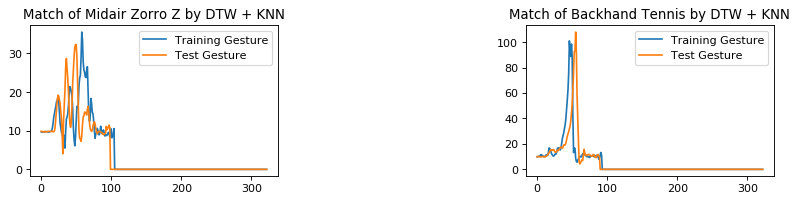

In [17]:
from random import randint

fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace = 1, hspace=0.4)

ax = fig.add_subplot(2, 2, 1)

ind = randint(0, (len(matched_gestures) / 2) - 1)
ax.plot(matched_gestures[ind], label="Training Gesture")
ax.plot(testing_data[ind].acceleration.mag, label="Test Gesture")
ax.set_title("Match of {} by DTW + KNN".format(testing_data[ind].gesture_name))
ax.legend(loc=1)

ax = fig.add_subplot(2, 2, 2)

ind = randint(0, (len(matched_gestures) / 2) - 1)
ax.plot(matched_gestures[ind], label="Training Gesture")
ax.plot(testing_data[ind].acceleration.mag, label="Test Gesture")
ax.set_title("Match of {} by DTW + KNN".format(testing_data[ind].gesture_name))
ax.legend(loc=1)

plt.show()


Clearly, the dynamic time warping algorithm does quite a good job at matching two related signals. 

### Precision and Recall of DTW + KNN

Now, we compute the overall accuracy of the DTW + KNN approach. I'm computing a confusion matrix as well as the precision and recall of the classifier.

                            precision    recall  f1-score   support

                   At Rest       1.00      1.00      1.00         2
           Backhand Tennis       1.00      1.00      1.00         3
           Forehand Tennis       0.50      1.00      0.67         1
        Midair Clockwise O       0.67      1.00      0.80         2
Midair Counter Clockwise O       1.00      0.50      0.67         2
                  Midair S       0.33      1.00      0.50         1
            Midair Zorro Z       1.00      0.50      0.67         4
                     Shake       1.00      1.00      1.00         7
         Underhand Bowling       1.00      0.50      0.67         2

                 micro avg       0.83      0.83      0.83        24
                 macro avg       0.83      0.83      0.77        24
              weighted avg       0.92      0.83      0.84        24


Overall Accuracy for DTW + KNN Classifier
0.8333333333333334


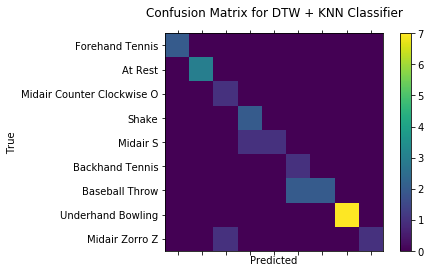

In [18]:
import itertools

# Compute confusion matrix
cnf_matrix = confusion_matrix(test, pred)

print (classification_report(test, pred))

#print("\nConfusion Matrix for DTW + KNN Classifier")
#print(cnf_matrix)

acc = accuracy_score(test, pred, normalize=True)
print("\nOverall Accuracy for DTW + KNN Classifier")
print(acc)

class_names = set()
for gesture in cleaned_provided_data:
    class_names.add(gesture)
    
class_names = list(class_names)

# Plot confusion matrix
# https://stackoverflow.com/a/19252430
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title("Confusion Matrix for DTW + KNN Classifier")
fig.colorbar(cax)
ax.set_xticklabels([''] )
ax.set_yticklabels([''] + class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model-Based Gesture Recognition 

I'm going to be using an svm from sklearn with a 1D input in the form of the max magnitude of the acceleration for each gesture.

In [ ]:
from sklearn import svm

folds = make_folds(5, cleaned_provided_data)
training_data = folds['training']
testing_data = folds['testing']

folds_recorded = make_folds(5, cleaned_recorded_data)
training_data_recorded = folds['training']
testing_data_recorded = folds['testing']


cleaned_training_data = numpy.array([])
training_data_labels = numpy.array([])

# adding the provided training data 
for fold in training_data:
    for i in range(len(fold)):
        cleaned_training_data = numpy.append(cleaned_training_data, fold[i].acceleration.mag.max())
        training_data_labels = numpy.append(training_data_labels, fold[i].gesture_name)
        
# adding the recorded training data        
for fold in training_data_recorded:
    for i in range(len(fold)):
        cleaned_training_data = numpy.append(cleaned_training_data, fold[i].acceleration.mag.max())
        training_data_labels = numpy.append(training_data_labels, fold[i].gesture_name)

cleaned_training_data = cleaned_training_data.reshape(-1, 1)

# create the svm and train
clf = svm.SVC()
clf.fit(cleaned_training_data, training_data_labels) 

y_pred = []
y_test = []

# making predictions on recorded gesture data 
for gesture in testing_data_recorded:
    y_test.append(gesture.gesture_name)
    svmPrediction = clf.predict(gesture.acceleration.mag.max())
    y_pred.append(svmPrediction[0])
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix for SVD Classifier")
print(cnf_matrix)

acc = accuracy_score(y_test, y_pred, normalize=True)
print(acc)


In [ ]:
import random

def create_simple_feature_vector(trial):
    return [trial.acceleration.mag.max(), trial.gyroscope.mag.max()]
    
# takes in the current testFold, the trainingFolds, and a create_feature_vector function
# the create_feature_vector function creates feature vectors given a Trial object
# I suggest creating multiple different create_feature_vector functions that you pass
# in here and test (this will allow you to easily compare different feature vectors)
def get_svm_input(testFold, trainingFolds, create_feature_vector):
    
    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
        
    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0]))
    numFeatures = len(create_feature_vector(tmpTrainingTrial))
    print("The feature vector size is: {}".format(numFeatures))
     
    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = numpy.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = numpy.array([])
  
    # Build up the training data and also keep track of the class labels (in trainingLabels)
    row = 0
    for trainingFold in trainingFolds:
        for trainingTrial in trainingFold:
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = numpy.append(trainingLabels, trainingTrial.gesture_name)
            trainingTrials.append(trainingTrial)
            row = row + 1
    
    # Now setup the testData data structure
    testData = numpy.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    
    for testTrial in testFold:
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testTrial.gesture_name)
        testRow = testRow + 1
    
    return [trainingData, trainingLabels, testData, groundtruthLabels]

svmInput = get_svm_input(testing_data, training_data, create_simple_feature_vector)

#cleaned_training_data = svmInput[0].reshape(-1, 1)

# create the svm and train
clf = svm.SVC()
clf.fit(svmInput[0], svmInput[1]) 

y_test = svmInput[3]

y_pred = clf.predict(svmInput[2])
    
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)

#print("Confusion Matrix for SVD Classifier")
#print(cnf_matrix)

acc = accuracy_score(y_test, y_pred, normalize=True)
print(acc)


